In [1]:
import os
os.chdir(os.path.join('..', 'src'))

import pandas as pd
import numpy as np
import skimage
from skimage.color import label2rgb, rgb2gray
from skimage.measure import label, regionprops_table, regionprops
from skimage.segmentation import expand_labels
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank, threshold_minimum
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.util import img_as_ubyte
from tifffile import imread, imwrite

data_dir = os.path.join('..', 'data')

In [2]:
pure_green = np.array([[[0,255,0]]])

radius = 30
footprint = disk(radius)

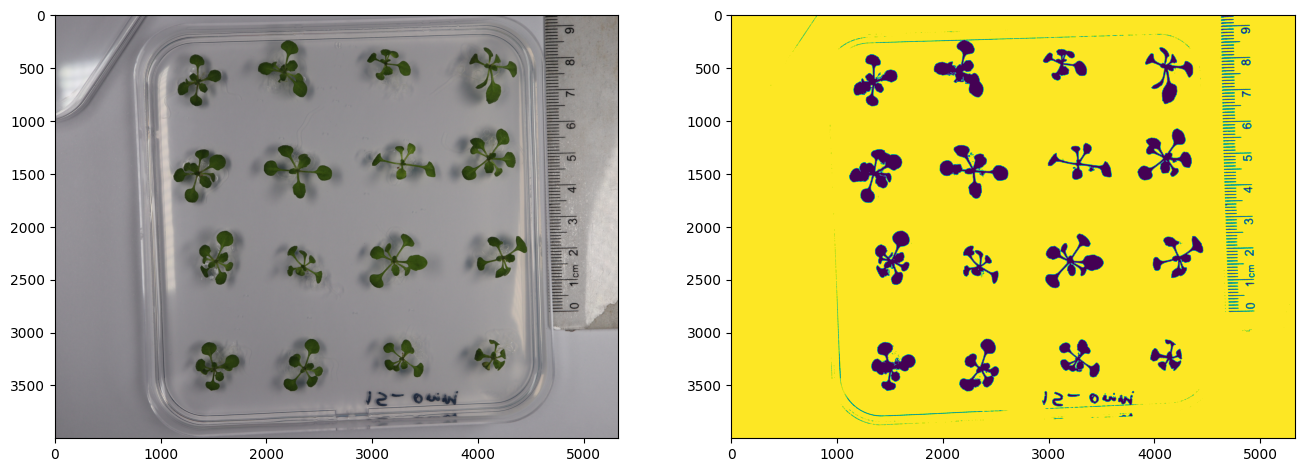

In [4]:
img_files = os.listdir(data_dir)
for file in img_files[:1]:
    # read image
    img = skimage.io.imread(os.path.join(data_dir, file))
    crop_img = img[2100:2600,2150:2650]
    # build difference to pure green and sum up color channels
    dist_to_green = np.abs(img - pure_green).sum(axis=-1)
    # find meaningful threshold to binarize image
    thres = threshold_otsu(dist_to_green)
    # try local otsu thresholding
    #local_otsu = rank.otsu(img_as_ubyte(dist_to_green), footprint)
    
    # generate plots for both input images
    crop_dist = dist_to_green[2100:2600,2150:2650]
    fig, axs = plt.subplots(ncols=2, figsize=(16,8))
    axs[0].imshow(img)
    axs[1].imshow(dist_to_green > thres)
    plt.show()

In [5]:
def plant_segmentation(img, ref_color=[0,255,0]):
    pure_green = np.array([[ref_color]])
    dist_to_green = np.abs(img - pure_green).sum(axis=-1)
    thres = threshold_minimum(dist_to_green)
    return dist_to_green < thres

ACDC data already existing for 15-0mM_3467. Not overwriting, skipping Image


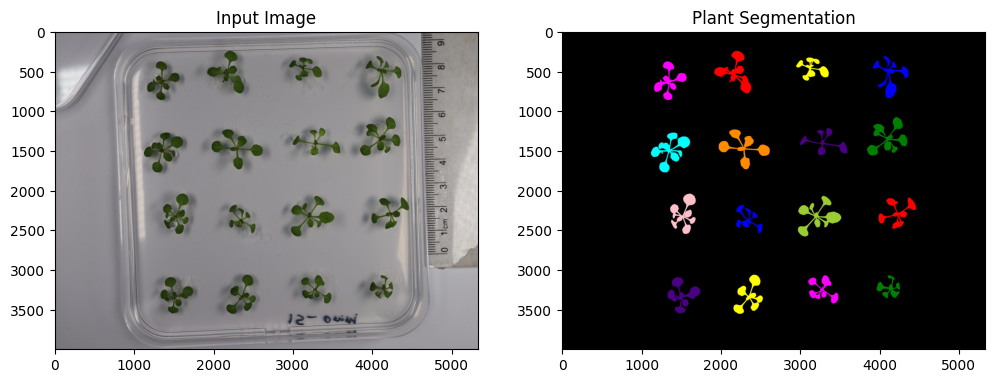

ACDC data already existing for 23-2 0mM_4542. Not overwriting, skipping Image


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x000001A938E45D30>
Traceback (most recent call last):
  File "C:\Users\mairhoermann\Anaconda3\envs\acdc_user\lib\site-packages\matplotlib\transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 

KeyboardInterrupt



In [6]:
for file in img_files:
    # read image
    img = skimage.io.imread(os.path.join(data_dir, file))
    binary_seg = plant_segmentation(img)
    
    # merge segmented objects based on their expanded label
    labeled = label(binary_seg)
    labeled = skimage.morphology.remove_small_objects(labeled, min_size=500) # after merging remove small objects
    expanded = expand_labels(binary_seg, distance=20)
    expanded_labeled = label(expanded)
    
    new_labeled = np.zeros(labeled.shape)
    for l_id in np.unique(labeled):
        if l_id>0:
            l_id_exp_ids = expanded_labeled[labeled==l_id]
            # expanded contains old objects, so there is only one new id for each old id
            assert len(np.unique(l_id_exp_ids))==1
            new_l_id = l_id_exp_ids[0]
            new_labeled[labeled==l_id] = new_l_id
    new_labeled = new_labeled.astype(int)
    new_labeled = skimage.morphology.remove_small_objects(new_labeled, min_size=1500)
    
    rp_table = regionprops_table(new_labeled, properties=['label', 'centroid', 'area', 'axis_major_length', 'axis_minor_length'])
    result_df = pd.DataFrame(rp_table)
    result_df['filename'] = file
    result_df['elongation'] = result_df.axis_major_length / result_df.axis_minor_length
    
    # eliminate elongated "plants"
    remove_labels = result_df[result_df.elongation>4].label
    for rl in remove_labels:
        new_labeled[new_labeled==rl] = 0
    
    acdc_basename = file.split('.')[0]
    acdc_img_path = os.path.join('..', 'acdc_data', acdc_basename, 'Position_1', 'Images')
    try:
        os.mkdir(os.path.join('..', 'acdc_data', acdc_basename))
        os.mkdir(os.path.join('..', 'acdc_data', acdc_basename, 'Position_1'))
        os.mkdir(acdc_img_path)
        imwrite(os.path.join(acdc_img_path, f'{acdc_basename}_grayscale.tif'), rgb2gray(img))
        metadata_df = pd.DataFrame({'Description':['basename'], 'values':[acdc_basename]}, index=None)
        metadata_df.to_csv(os.path.join(acdc_img_path, f'{acdc_basename}_metadata.csv'))
        np.savez_compressed(os.path.join(acdc_img_path, f'{acdc_basename}_segm.npz'), new_labeled)
    except FileExistsError:
        print(f'ACDC data already existing for {acdc_basename}. Not overwriting, skipping Image')
        pass
    
    
    
    fig, axs = plt.subplots(ncols=2, figsize=(12,6))
    axs[0].imshow(img)
    axs[0].set_title('Input Image')
    axs[1].imshow(label2rgb(new_labeled))
    axs[1].set_title('Plant Segmentation')
    plt.show()


In [21]:
pd.DataFrame({'Description':['basename'], 'values':[acdc_basename]}, index=None)

,Description,values
0,basename,15-0mM_3467


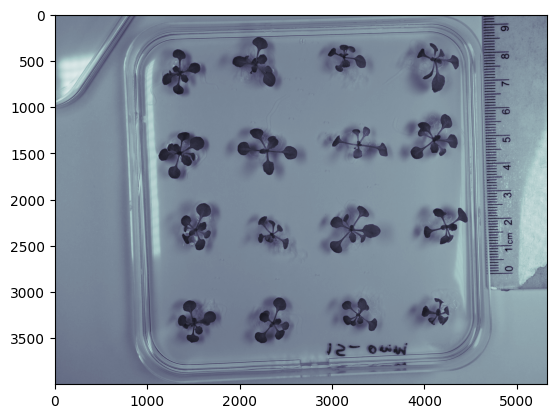

In [19]:
plt.imshow(rgb2gray(img), cmap='bone')